In [1]:
import numpy as np
import os
import time
from vgg16 import VGG16
from keras.preprocessing import image
from keras.applications.imagenet_utils import preprocess_input
from imagenet_utils import decode_predictions
from keras.layers import Dense, Activation, Flatten
from keras.layers import merge, Input
from keras.models import Model
from keras.utils import np_utils
from sklearn.utils import shuffle
from sklearn.cross_validation import train_test_split

Using TensorFlow backend.
C:\Users\jazari2\Anaconda3\envs\test1_env\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
data_path = 'D:/Gaurav/pp/data/'

In [3]:
data_dir_list = os.listdir(data_path)

In [ ]:
img_data_list = []

for dataset in data_dir_list:
    img_list = os.listdir(data_path + '/'+ dataset)
    print('image of dataset -'+' {}'.format(dataset))
    
    for img in img_list:
        img_path = data_path + '/' + dataset + '/' + img 
        img = image.load_img(img_path , target_size=(244,244))
        x = image.img_to_array(img)
        x = np.expand_dims(x , axis=0)
        x = preprocess_input(x)
        print('image_shape ', x.shape)
        img_data_list.append(x)

In [5]:
img_data = np.array(img_data_list)
img_data.shape

(808, 1, 244, 244, 3)

In [6]:
img_data = np.rollaxis(img_data , 1, 0)
img_data.shape

(1, 808, 244, 244, 3)

In [7]:
img_data = img_data[0]
img_data.shape

(808, 244, 244, 3)

In [8]:
num_classes = 4
num_of_samples =  img_data.shape[0]

In [9]:
labels = np.ones((num_of_samples) , dtype='int64')

In [10]:
labels[0:202]=0
labels[202:404] =1
labels[404:606]=2
labels[606:]=3

In [11]:
names = ['cats' , 'dogs' , 'horses' , 'humans']

In [12]:
Y = np_utils.to_categorical(labels , 4)

In [13]:
x  , y = shuffle( img_data , Y , random_state=4)

In [14]:
X_train , X_test , Y_train , Y_test = train_test_split( x, y , test_size = 0.2 , random_state=4)

###  VGG_Model

In [15]:
image_input = Input(shape=(244, 244 , 3))

In [16]:
model = VGG16(input_tensor=image_input , include_top=True , weights = 'imagenet')

In [17]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 244, 244, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 244, 244, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 244, 244, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 122, 122, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 122, 122, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 122, 122, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 61, 61, 128)       0         
__________

### Change Number of Input in fc2 number of out_put is 1000 but In our case we need only 4( cat , dog , horses , human)

In [18]:
last_layer = model.get_layer('fc2').output

### Also change last Layer output 

In [19]:
out = Dense(num_classes , activation='softmax' , name = 'output')(last_layer)
custom_vgg_model = Model(image_input , out )

In [20]:
custom_vgg_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 244, 244, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 244, 244, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 244, 244, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 122, 122, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 122, 122, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 122, 122, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 61, 61, 128)       0         
__________

# Train as Classifier

###  Disable all layer except last layer

In [21]:
custom_vgg_model.layers[3].trainable

True

In [22]:
for layer in custom_vgg_model.layers[:-1]:
    layer.trainable = False

In [23]:
custom_vgg_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 244, 244, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 244, 244, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 244, 244, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 122, 122, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 122, 122, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 122, 122, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 61, 61, 128)       0         
__________

In [24]:
custom_vgg_model.layers[3].trainable

False

In [25]:
custom_vgg_model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

In [26]:
hist = custom_vgg_model.fit(X_train, Y_train, batch_size=8, epochs=12, verbose=1, validation_data=(X_test, Y_test))

Train on 646 samples, validate on 162 samples
Epoch 1/12
646/646 [==============================] - 210s 324ms/step - loss: 0.2187 - acc: 0.9412 - val_loss: 0.0765 - val_acc: 0.9630
Epoch 2/12
646/646 [==============================] - 210s 324ms/step - loss: 0.0151 - acc: 0.9923 - val_loss: 0.0389 - val_acc: 0.9753
Epoch 3/12
646/646 [==============================] - 209s 324ms/step - loss: 0.0012 - acc: 1.0000 - val_loss: 0.0488 - val_acc: 0.9753
Epoch 4/12
646/646 [==============================] - 209s 324ms/step - loss: 0.0010 - acc: 1.0000 - val_loss: 0.0238 - val_acc: 0.9877
Epoch 5/12
646/646 [==============================] - 209s 324ms/step - loss: 1.5737e-05 - acc: 1.0000 - val_loss: 0.0341 - val_acc: 0.9815
Epoch 6/12
646/646 [==============================] - 210s 325ms/step - loss: 1.5163e-05 - acc: 1.0000 - val_loss: 0.0157 - val_acc: 0.9877
Epoch 7/12
646/646 [==============================] - 210s 324ms/step - loss: 3.5682e-06 - acc: 1.0000 - val_loss: 0.0139 - val_ac

In [28]:
(loss, accuracy) = custom_vgg_model.evaluate(X_test, Y_test, batch_size=10, verbose=1)

162/162 [==============================] - 42s 256ms/step


In [29]:
print("[INFO] loss={:.4f}, accuracy: {:.4f}%".format(loss,accuracy * 100))



[INFO] loss=0.0101, accuracy: 99.3827%


# visualizing losses and accuracy

In [30]:
import matplotlib.pyplot as plt

In [33]:
train_loss=hist.history['loss']
val_loss=hist.history['val_loss']
train_acc=hist.history['acc']
val_acc=hist.history['val_acc']
xc=range(12)

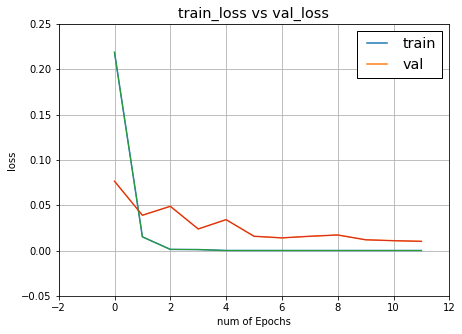

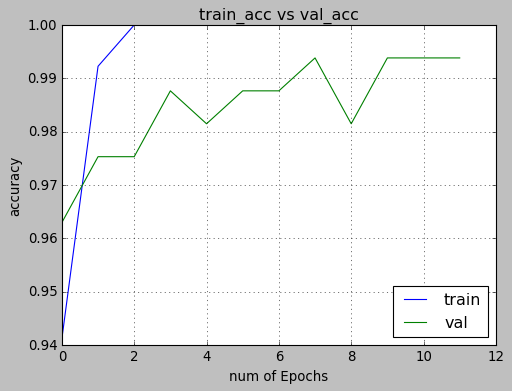

In [36]:
plt.figure(1,figsize=(7,5))
plt.plot(xc,train_loss)
plt.plot(xc,val_loss)
plt.xlabel('num of Epochs')
plt.ylabel('loss')
plt.title('train_loss vs val_loss')
plt.grid(True)
plt.legend(['train','val'])
plt.style.available # use bmh, classic,ggplot for big pictures
plt.style.use(['classic'])
plt.show()

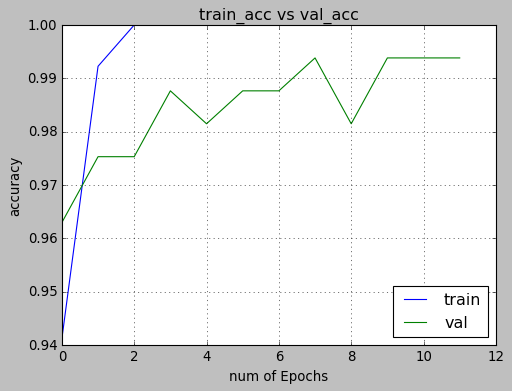

In [38]:
plt.figure(2,figsize=(7,5))
plt.plot(xc,train_acc)
plt.plot(xc,val_acc)
plt.xlabel('num of Epochs')
plt.ylabel('accuracy')
plt.title('train_acc vs val_acc')
plt.grid(True)
plt.legend(['train','val'],loc=4)
plt.style.available # use bmh, classic,ggplot for big pictures
plt.style.use(['classic'])
plt.show()

# Training the feature extraction

In [39]:
image_input = Input(shape = (244,244,3))

In [41]:
model = VGG16(input_tensor = image_input , include_top = True , weights = 'imagenet')
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 244, 244, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 244, 244, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 244, 244, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 122, 122, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 122, 122, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 122, 122, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 61, 61, 128)       0         
__________

In [43]:
last_layer = model.get_layer('block5_pool').output
x = Flatten(name = 'flatten')(last_layer)

In [44]:
X = Dense(128 , activation = 'relu',name = 'fc1')(x)
X = Dense(128 , activation = 'relu',name = 'fc2')(x)


In [46]:
output = Dense(4 , activation='softmax', name='output')(x)

In [48]:
custom_vgg_model2 = Model(image_input ,  output)
custom_vgg_model2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 244, 244, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 244, 244, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 244, 244, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 122, 122, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 122, 122, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 122, 122, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 61, 61, 128)       0         
__________

###  freeze all the layers except the dense layers

In [50]:
for layer in custom_vgg_model2.layers[:-3]:
    layer.trainable = False

In [51]:
custom_vgg_model2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 244, 244, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 244, 244, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 244, 244, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 122, 122, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 122, 122, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 122, 122, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 61, 61, 128)       0         
__________

In [52]:
custom_vgg_model2.compile(loss='categorical_crossentropy',optimizer='adadelta',metrics=['accuracy'])

In [55]:
hist = custom_vgg_model2.fit(X_train, Y_train, batch_size=32, epochs=10, verbose=1, validation_data=(X_test, Y_test))

Train on 646 samples, validate on 162 samples
Epoch 1/10
646/646 [==============================] - 204s 316ms/step - loss: 2.7729 - acc: 0.7709 - val_loss: 1.5541 - val_acc: 0.8765
Epoch 2/10
646/646 [==============================] - 204s 315ms/step - loss: 0.5292 - acc: 0.9567 - val_loss: 0.3242 - val_acc: 0.9568
Epoch 3/10
646/646 [==============================] - 201s 311ms/step - loss: 0.4494 - acc: 0.9644 - val_loss: 0.4900 - val_acc: 0.9444
Epoch 4/10
646/646 [==============================] - 203s 314ms/step - loss: 0.3276 - acc: 0.9737 - val_loss: 0.1436 - val_acc: 0.9877
Epoch 5/10
646/646 [==============================] - 203s 314ms/step - loss: 0.1248 - acc: 0.9923 - val_loss: 0.1432 - val_acc: 0.9877
Epoch 6/10
646/646 [==============================] - 203s 314ms/step - loss: 0.1248 - acc: 0.9923 - val_loss: 0.1432 - val_acc: 0.9877
Epoch 7/10
646/646 [==============================] - 203s 313ms/step - loss: 0.1248 - acc: 0.9923 - val_loss: 0.1432 - val_acc: 0.9877
Ep

In [57]:
(loss, accuracy) = custom_vgg_model2.evaluate(X_test, Y_test, batch_size=10, verbose=1)

print("[INFO] loss={:.4f}, accuracy: {:.4f}%".format(loss,accuracy * 100))


162/162 [==============================] - 40s 249ms/step
[INFO] loss=0.1433, accuracy: 98.7654%


# visualizing losses and accuracy

In [61]:
import matplotlib.pyplot as plt

In [65]:
train_loss=hist.history['loss']
val_loss=hist.history['val_loss']
train_acc=hist.history['acc']
val_acc=hist.history['val_acc']
xc=range(10)

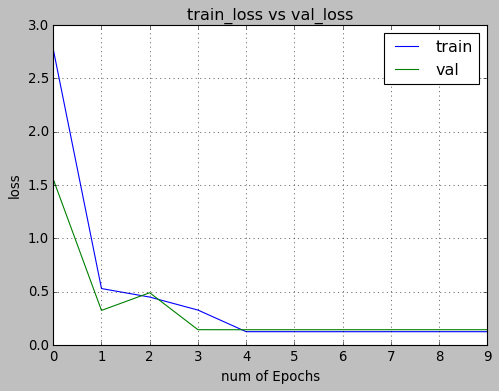

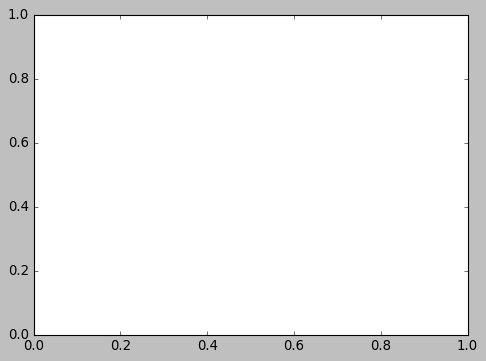

In [66]:
plt.figure(1,figsize=(7,5))
plt.plot(xc,train_loss)
plt.plot(xc,val_loss)
plt.xlabel('num of Epochs')
plt.ylabel('loss')
plt.title('train_loss vs val_loss')
plt.grid(True)
plt.legend(['train','val'])
plt.style.available # use bmh, classic,ggplot for big pictures
plt.style.use(['classic'])
plt.show()

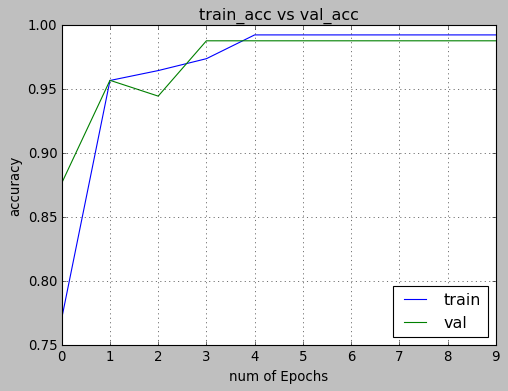

In [67]:
plt.figure(2,figsize=(7,5))
plt.plot(xc,train_acc)
plt.plot(xc,val_acc)
plt.xlabel('num of Epochs')
plt.ylabel('accuracy')
plt.title('train_acc vs val_acc')
plt.grid(True)
plt.legend(['train','val'],loc=4)
plt.style.available # use bmh, classic,ggplot for big pictures
plt.style.use(['classic'])
plt.show()